In [ ]:
!pip3 install keras==2.2.5
!pip3 install --upgrade h5py==2.10.0
!pip3 install -U scikit-image==0.16.2
%tensorflow_version 1.x
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 336 kB 6.5 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 6.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not curr

In [ ]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git"
!unzip dataset2.zip


Cloning into 'wastedata-Mask_RCNN-multiple-classes'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 12.19 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Archive:  dataset2.zip
   creating: dataset2/
   creating: dataset2/test/
  inflating: dataset2/test/image_test.jpg  
   creating: dataset2/train/
  inflating: dataset2/train/img (1).jpg  
  inflating: dataset2/train/img (10).jpg  
  inflating: dataset2/train/img (11).jpg  
  inflating: dataset2/train/img (12).jpg  
  inflating: dataset2/train/img (13).jpg  
  inflating: dataset2/train/img (14).jpg  
  inflating: dataset2/train/img (15).jpg  
 extracting: dataset2/train/img (16).jpg  
  inflating: dataset2/train/img (17).jpg  
  inflating: dataset2/train/img (18).jpg  
  inflating: dataset2/train/img (19).jpg  
  inflating: dataset2/train/img (2).jpg  
  inflating: dataset2/train/img (20).jpg  
  inflating: dataset2/train/img (3

In [ ]:
import shutil, os, sys

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2

import matplotlib.pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + (feuille, tige and pot)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 250
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

Using TensorFlow backend.


In [ ]:
!nvidia-smi

Thu Jun  9 11:21:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "feuille")
        self.add_class("object", 2, "tige")
        self.add_class("object", 3, "pot") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()] 
            objects = [s['region_attributes']['label'] for s in a['regions'].values()]
            print("objects:",objects)
            name_dict = {"feuille": 1,"tige": 2,"pot": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/dataset2", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/dataset2", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
... done downloading pretrained model!


In [ ]:
train(model)

objects: ['feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'pot']
numids [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3]
objects: ['pot', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'feuille', 'feuille', 'feuille', 'feuille']
numids [3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
objects: ['feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'pot']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]
objects: ['pot', 'tige', 'feuille']
numids [3, 2, 1]
objects: ['feuille', 'tige', 'pot']
numids [1, 2, 3]
objects: ['pot', 'feuille']
numids [3, 1]
objects: ['feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'tige', 'pot']
numids [1, 1, 1, 1, 1, 1, 2, 3]
objects: ['pot', 'tige', 'tige', '

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
250/250 [==============================] - 369s 1s/step - loss: 1.3816 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 0.3637 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.3384 - val_loss: 3.0612 - val_rpn_class_loss: 0.2102 - val_rpn_bbox_loss: 1.3248 - val_mrcnn_class_loss: 0.7244 - val_mrcnn_bbox_loss: 0.4965 - val_mrcnn_mask_loss: 0.3053

Epoch 2/10
250/250 [==============================] - 260s 1s/step - loss: 0.6403 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.1282 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2366 - val_loss: 3.2219 - val_rpn_class_loss: 0.2639 - val_rpn_bbox_loss: 1.3393 - val_mrcnn_class_loss: 0.7361 - val_mrcnn_bbox_loss: 0.5623 - val_mrcnn_mask_loss: 0.3204
Epoch 3/10
250/250 [==============================] - 260s 1s/step - loss: 0.5383 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.2021 - val_loss: 4.1950 - val_rpn_clas

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Root directory of the project
#ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
WEIGHTS_PATH = "/content/mask_rcnn_object_0010.h5"  # TODO: update this path

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/dataset/")
class InferenceConfig(config.__class__):
  # Run detection on one image at a time
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Device to load the neural network on. Useful if you're training a model on the same machine, in which case use CPU and leave the GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
CUSTOM_DIR = "/content/dataset2"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'tige', 'pot']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3]
objects: ['pot', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'tige', 'tige', 'tige', 'tige', 'tige']
numids [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
objects: ['pot', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille']
numids [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['pot', 'tige', 'tige', 'tige', 'tige', 'feuille', 'feuille', 'feuille', 'feuille', 'feuille']
numids [3, 2, 2, 2, 2, 1, 1, 1, 1, 1]
objects: ['feuille', 'feuille', 'feuille', 'feuille', 'tige', 'pot']
numids [1, 1, 1, 1, 2, 3]
Images: 5
Classes: ['BG', 'feuille', 'tige', 'pot']


In [ ]:
#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/mask_rcnn_object_0010.h5


1
image ID: object.img (2).jpg (1) /content/dataset2/val/img (2).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (17,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (17, 4)               min:  139.00000  max:  840.00000  int32
gt_mask                  shape: (1024, 1024, 17)      min:    0.00000  max:    1.00000  uint8


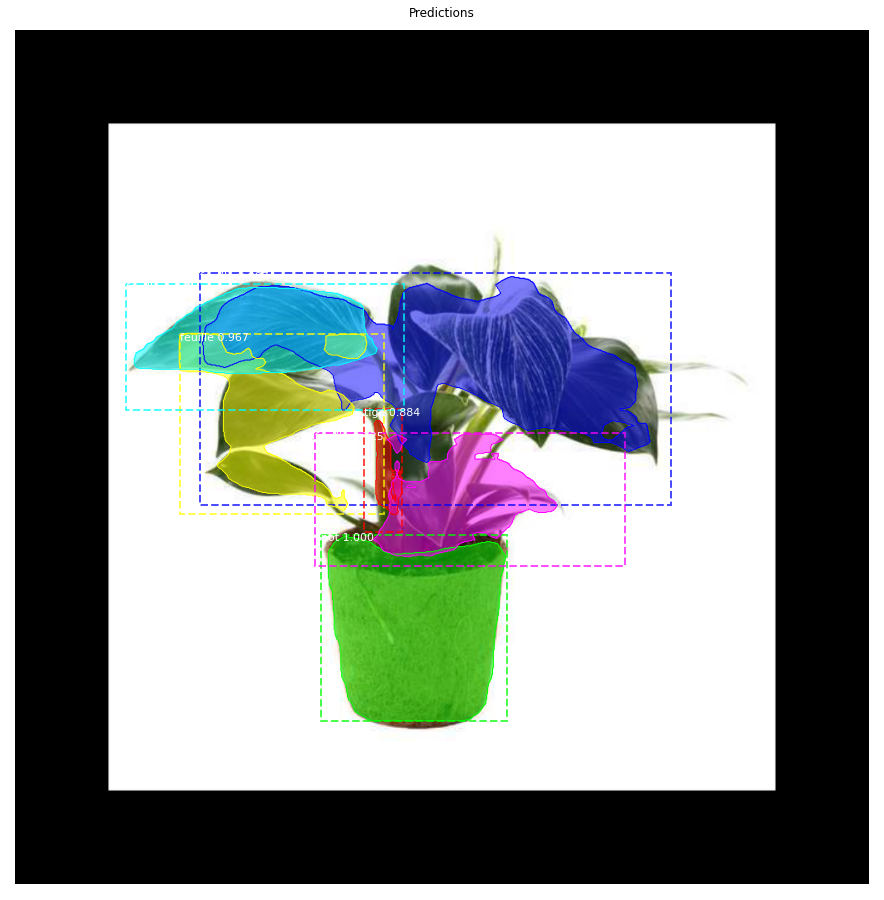

In [ ]:
#RUN DETECTION
image_id = random.choice(dataset.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
x = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=x, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


1
Processing 1 images
image                    shape: (553, 553, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (17,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (17, 4)               min:  139.00000  max:  840.00000  int32
gt_mask                  shape: (1024, 1024, 17)      min:    0.00000  max:    1.00000  uint8


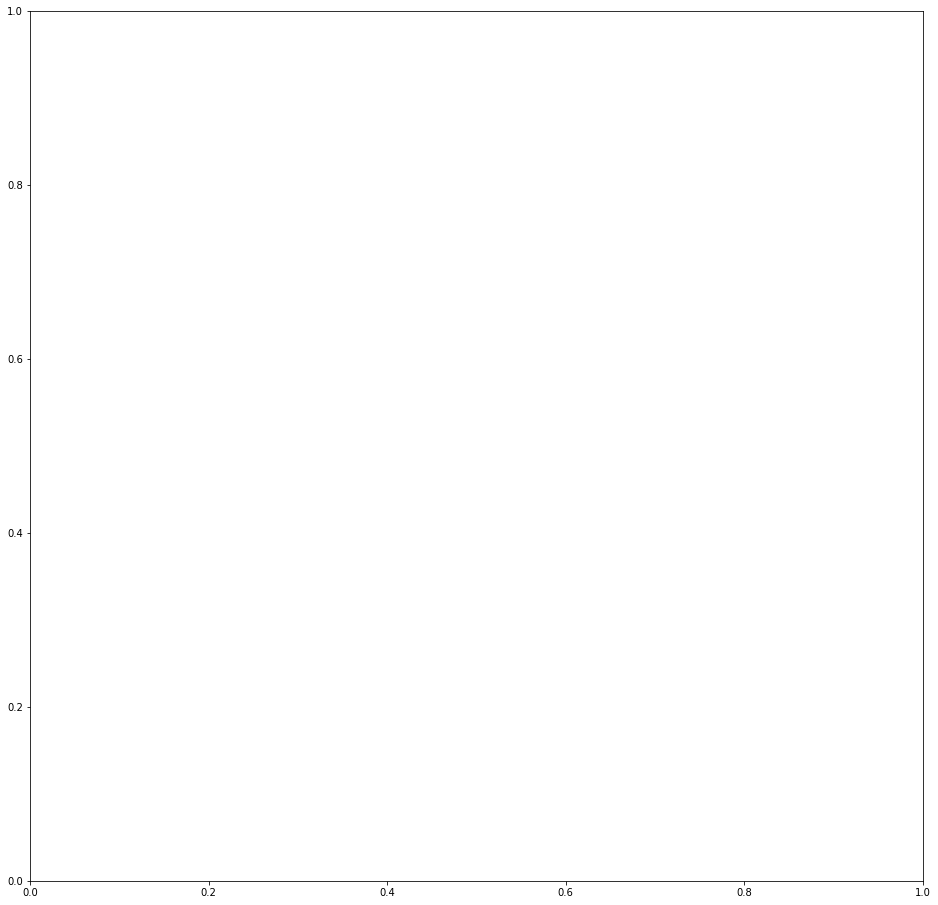

In [ ]:
# This is for predicting images which are not present in dataset
path_to_new_image = r'/content/dataset2/test/image_test.jpg'
image1 = mpimg.imread(path_to_new_image)
# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=x, title="Predictions1")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)